In [4]:
import cv2
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image, ImageFilter
from tqdm import tqdm
import os

In [10]:
!mkdir ../tmp
!mkdir ../tmp/masks
!mkdir ../tmp/inlines

In [13]:
!aws s3 cp --recursive --quiet s3://ml-for-seismic-data-interpretation/raw_data/masks ../tmp/masks/

In [14]:
!aws s3 cp --recursive --quiet s3://ml-for-seismic-data-interpretation/raw_data/inlines ../tmp/inlines/

In [22]:
masks = sorted(glob('../tmp/masks/*.png'))
masks[:5]

['../tmp/masks/kerry_511.png',
 '../tmp/masks/kerry_512.png',
 '../tmp/masks/kerry_513.png',
 '../tmp/masks/kerry_514.png',
 '../tmp/masks/kerry_515.png']

In [25]:
len(masks)

3810

In [23]:
inlines = sorted(glob('../tmp/inlines/*.png'))

In [24]:
len(inlines)

3810

## Preprocess Mask

Problem: Horizons on masks are very thin

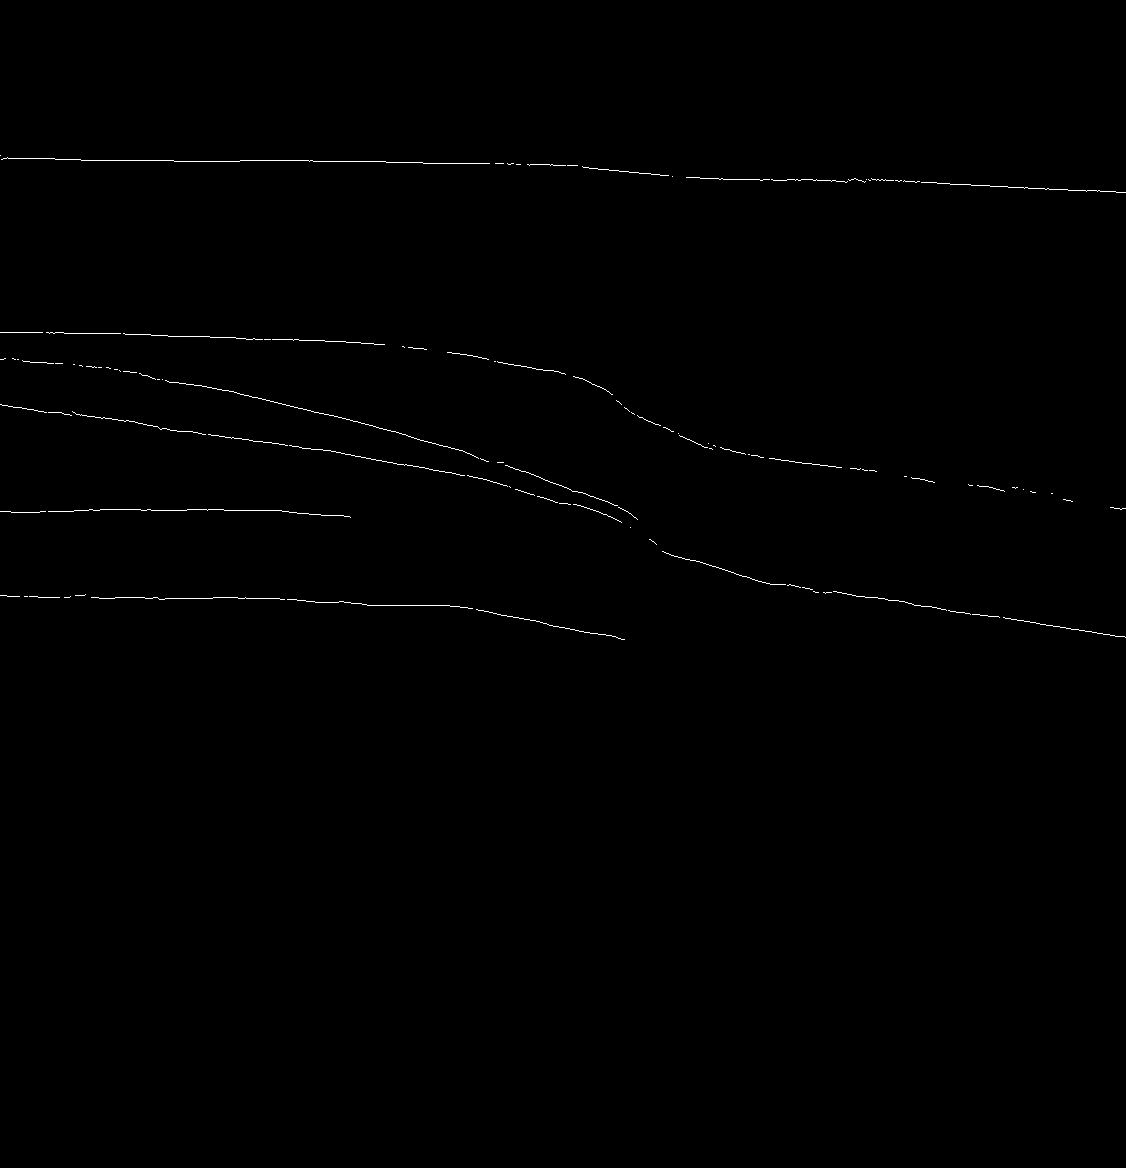

In [26]:
sample_mask = Image.open(masks[1000])
sample_mask

In [27]:
kernel_size = 3

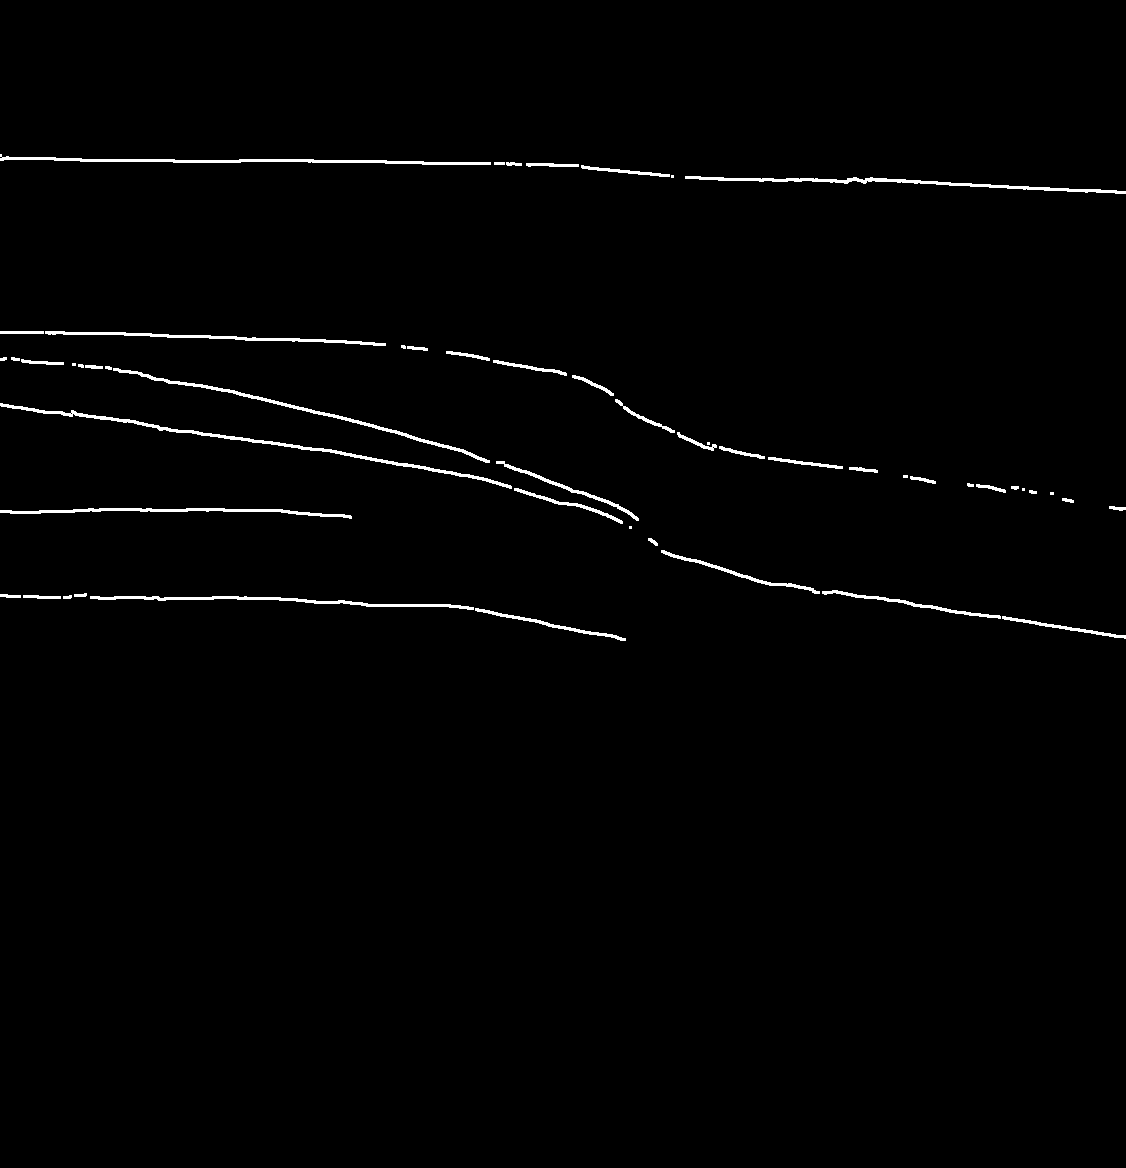

In [28]:
sample_mask.filter(ImageFilter.MaxFilter(kernel_size))

## Opt 1 - Use all three volumes for train-validation-test

Select batches from all three volumes and distribute those batches in train validation and test sets, while skipping some inlines in between.

30(train)-5(skip)-10(val)-5(skip)-10(test)-5(skip)

In [29]:
!mkdir ../tmp/train
!mkdir ../tmp/validation
!mkdir ../tmp/train_annotation
!mkdir ../tmp/validation_annotation
!mkdir ../tmp/test
!mkdir ../tmp/test_annotation

In [31]:
split_size = 65
train_range = range(0,30)
skip_range = list(range(30, 35))+ list(range(45,50)) + list(range(60, 65))
val_range = range(35,45)
test_range = range(50, 60)

In [33]:
for idx, (inline_path, mask_path) in tqdm(enumerate(zip(inlines, masks))):
    if idx % split_size in skip_range:
        continue
    else:
        inline = Image.open(inline_path)
        inline = inline.convert('RGB')
        mask = Image.open(mask_path)
        mask = mask.filter(ImageFilter.MaxFilter(kernel_size))
        inline_idx = inline_path.split(os.path.sep)[-1].split('.')[0]
        
        if idx % split_size in train_range:
            mask.save(f'../tmp/train_annotation/{inline_idx}.png', mode='P')
            inline.save(f'../tmp/train/{inline_idx}.jpg')
        elif idx % split_size in val_range:
            mask.save(f'../tmp/validation_annotation/{inline_idx}.png', mode='P')
            inline.save(f'../tmp/validation/{inline_idx}.jpg')
        elif idx % split_size in test_range:
            mask.save(f'../tmp/test_annotation/{inline_idx}.png', mode='P')
            inline.save(f'../tmp/test/{inline_idx}.jpg')

3810it [28:20,  2.24it/s]


## Opt 2 - Use a separate volume for test. 
Using a separate volume(s) for the test is a suitable and recommended option if there are multiple volumes with good horizon annotations. In our case, Kerry volume has very limited horizon annotations, so we will have only one properly annotated volume(Poseidon) for train and val and one (Parihaka) for the test. Such setup might lead to overfitting towards Poseidon, therefore, we will use Opt 1 by default. 

In [20]:
# !mkdir ../tmp/test
# !mkdir ../tmp/test_annotation

In [21]:
# for inline_path, mask_path in tqdm(zip(inlines, masks)):
#     if 'parihaka' in inline_path:
#         inline = Image.open(inline_path)
#         mask = Image.open(mask_path)
#         mask = mask.filter(ImageFilter.MaxFilter(kernel_size))
        
#         inline_idx = inline_path.split(os.path.sep)[-1].split('.')[0]
#         mask.save(f'tmp/test_annotation/{inline_idx}.png', mode='P')
        
#         inline = inline.convert('RGB')
#         inline.save(f'tmp/test/{inline_idx}.jpg')

### Train-Val

30(train)-5(skip)-10(val)-5(skip)

In [13]:
# !mkdir ../tmp/train
# !mkdir ../tmp/validation
# !mkdir ../tmp/train_annotation
# !mkdir ../tmp/validation_annotation
# !mkdir ../tmp/test
# !mkdir ../tmp/test_annotation

In [11]:
# filter_inlines = filter(lambda x: 'kerry' in x or 'poseidon' in x, inlines)
# filter_masks = filter(lambda x: 'kerry' in x or 'poseidon' in x, masks)


In [16]:
# split_size = 50
# train_range = range(0,30)
# skip_range = list(range(30, 35))+ list(range(45,50))
# val_range = range(35,45)

In [ ]:
# for idx, (inline_path, mask_path) in tqdm(enumerate(zip(filter_inlines, filter_masks))):
#     if idx % split_size in skip_range:
#         continue
#     else:
#         inline = Image.open(inline_path)
#         inline = inline.convert('RGB')
#         mask = Image.open(mask_path)
#         mask = mask.filter(ImageFilter.MaxFilter(kernel_size))
#         inline_idx = inline_path.split(os.path.sep)[-1].split('.')[0]
        
#         if idx % split_size in train_range:
#             mask.save(f'tmp/train_annotation/{inline_idx}.png', mode='P')
#             inline.save(f'tmp/train/{inline_idx}.jpg')
#         elif idx % split_size in val_range:
#             mask.save(f'tmp/validation_annotation/{inline_idx}.png', mode='P')
#             inline.save(f'tmp/validation/{inline_idx}.jpg')

Note: As the manual annotations and semi-automated annotation interpolation process is not perfect; some of the inlines or masks may be incorrect, it is always recommended to run some EDA or perform manual data analysis.

## Export to S3

Before export, it is recommended to perform EDA or manual data filtering and validation. In this case, Kerry seismic volume is having a large number of faults, and misalignments, therefore, automatic horizon interpolation works badly, so very few Kerry frames are included in either set after the EDA.
Datasets with manyally filtered inlines were uploaded to S3 and could be downloaded directly from there.

In [7]:
import os
os.chdir('../tmp')

In [1]:
!zip -r -q train-val.zip train/ train_annotation/ validation/ validation_annotation/

^C


zip error: Interrupted (aborting)


In [2]:
!aws s3 cp train-val.zip s3://ml-for-seismic-data-interpretation/dataset/

^C
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/bin/aws", line 27, in <module>
    sys.exit(main())
  File "/home/ec2-user/anaconda3/envs/python3/bin/aws", line 23, in main
    return awscli.clidriver.main()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/awscli/clidriver.py", line 68, in main
    driver = create_clidriver()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/awscli/clidriver.py", line 78, in create_clidriver
    event_hooks=session.get_component('event_emitter'))
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/awscli/plugin.py", line 44, in load_plugins
    modules = _import_plugins(plugin_mapping)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/awscli/plugin.py", line 61, in _import_plugins
    module = __import__(path, fromlist=[module])
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/awscli/handlers.py", l

In [9]:
!zip -r -q test.zip test/*.jpg test_annotation/*.png

In [4]:
!aws s3 cp test.zip s3://ml-for-seismic-data-interpretation/dataset/


The user-provided path test.zip does not exist.


### Remove tmp folder

In [ ]:
!rm -rf tmp